Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset extracted.
Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/51
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.6522 - loss: 0.7595
Epoch 1: val_loss improved from inf to 0.51251, saving model to /content/drive/MyDrive/best_efficientnetb0_binary_sgd.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.6531 - loss: 0.7580 - val_accuracy: 0.7409 - val_loss: 0.5125 - learning_rate: 0.0010
Epoch 2/51
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.8018 - loss: 0.4543
Epoch 2: val_loss improved from 0.51251 to 0.37727, saving model to /content/drive/MyDrive/best_efficientnetb0_binary_sgd.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 519ms/step - accuracy: 0.8019 - loss: 0.4541 - val_accuracy: 0.8121 - val_loss: 0.3773 - learning_rate: 0.0010
Epoch 3/51
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8275 - loss: 0.4157
Epoch 3: val_loss improved from 0.37727 to 0.32996, saving model to /content/drive/MyDrive/best_efficientnetb0_binary_sgd.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 528ms/step - accuracy: 0.8276 - loss: 0.4155 - va

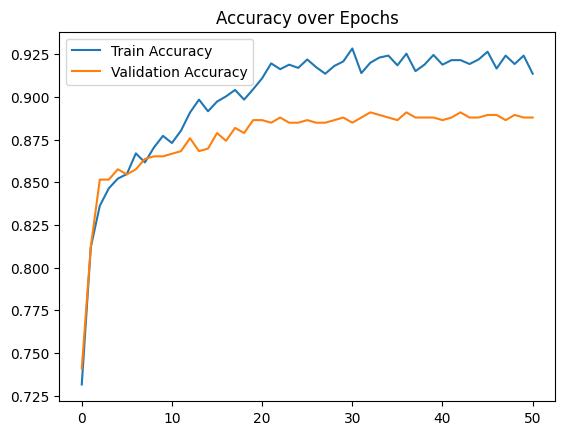

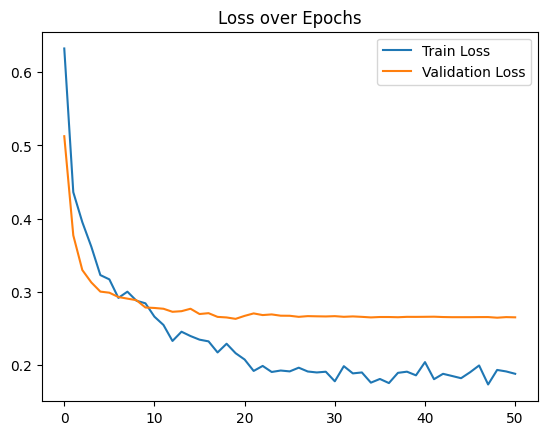

✅ Model loaded from: /content/drive/MyDrive/best_efficientnetb0_binary_sgd.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 436ms/step

✅ Overall Validation Accuracy: 88.64%


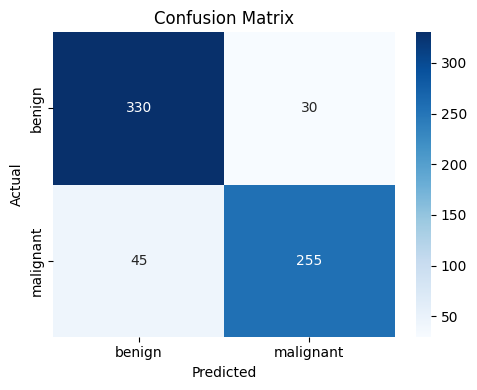


Classification Report:

              precision    recall  f1-score   support

      benign       0.88      0.92      0.90       360
   malignant       0.89      0.85      0.87       300

    accuracy                           0.89       660
   macro avg       0.89      0.88      0.88       660
weighted avg       0.89      0.89      0.89       660



IndexError: index 1 is out of bounds for axis 1 with size 1

In [9]:
# -*- coding: utf-8 -*-
"""efficientnetB0_binary_sgd.ipynb"""

from google.colab import drive
drive.mount('/content/drive')

import zipfile, os

# === Dataset Extraction ===
zip_path = "/content/drive/MyDrive/d.zip"
extract_path = "/content/dataset"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("✅ Dataset extracted.")

# === Imports ===
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import collections

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

# === Dataset Paths ===
train_dir = "/content/dataset/d/train"
val_dir = "/content/dataset/d/val"

# === Data Generators ===
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# === Model Definition ===
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze first 100 layers
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

# Custom head
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(2, activation='softmax')(x)   # ✅ 2 classes

model = Model(inputs=base_model.input, outputs=output)

# === Optimizer SGD + Momentum (with Nesterov) ===
optimizer = SGD(
    learning_rate=0.001,   # good starting point
    momentum=0.9,          # momentum term
    nesterov=True          # set False if you want classic momentum only
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.build((None, 224, 224, 3))

# === Callbacks ===
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/best_efficientnetb0_binary_sgd.keras",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# === Training ===
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=51,
    callbacks=[checkpoint, lr_scheduler]
)

# === Save Accuracy & Loss Plots ===
graph_dir = "/content/drive/MyDrive/diabetic_eye_results"
os.makedirs(graph_dir, exist_ok=True)

plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(); plt.title("Accuracy over Epochs")
plt.savefig(f"{graph_dir}/accuracy_plot.png")
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(); plt.title("Loss over Epochs")
plt.savefig(f"{graph_dir}/loss_plot.png")
plt.show()

# === Load Best Model for Evaluation ===
model_path = "/content/drive/MyDrive/best_efficientnetb0_binary_sgd.keras"
model = tf.keras.models.load_model(model_path)
print("✅ Model loaded from:", model_path)

# === Predictions ===
val_data.reset()
pred_probs = model.predict(val_data, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_data.classes

class_indices = val_data.class_indices
index_to_label = {v: k for k, v in class_indices.items()}
valid_labels = sorted(index_to_label.keys())
target_names = [index_to_label[i] for i in valid_labels]

print("\n✅ Overall Validation Accuracy: {:.2f}%".format(accuracy_score(y_true, y_pred) * 100))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=valid_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{graph_dir}/confusion_matrix.png")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    labels=valid_labels,
    target_names=target_names,
    zero_division=0
))

# === ROC Curve (binary) ===
n_classes = 2
labels = target_names
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    if np.sum(y_true_bin[:, i]) == 0:
        continue
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7, 6))
for i in range(n_classes):
    if i in roc_auc:
        plt.plot(fpr[i], tpr[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{graph_dir}/roc_curve.png")
plt.show()

# === Save Final Model ===
model.save("/content/drive/MyDrive/final_efficientnetb0_binary_sgd.keras")
print("✅ Final model saved.")
